## Request last 15-min of data from the Seafloor CTD in Real-Time (ASHES at Axial Seamount; MJ03B)
*Developed by Friedrich Knuth, Rutgers University, May 7, 2018*

*Modified by Lori Garzio, Rutgers University, July 11, 2018*

*Adapted by Bill Chadwick, August 14 2018*


In [1]:
username = 'OOIAPI-8PGYR9GA7YHVXX'
token = '0MT4ME7UEL5Y8L'

In [2]:
import datetime
import requests
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import netCDF4 as nc
from IPython import display

In this example we will build real-time requests for data from the Cabled Axial Seamount (RS03ASHS) - ASHES vent field (MJ03B) - Seafloor CTD (10-CTDPFB304) sensor. The ingredients being used to build the data_request_url can be found here: http://ooi.visualocean.net/instruments/view/RS03ASHS-MJ03B-10-CTDPFB304. To build an M2M request, you need the Reference Designator, Delivery Method and Data Stream Name. Note that streams containing science data products for a given instrument are designated as Science in the Type column.

In [3]:
# Instrument Information
subsite = 'RS03ASHS'
node = 'MJ03B'
sensor = '10-CTDPFB304'
method = 'streamed'
stream = 'ctdpf_optode_sample'

The code will start by requesting the last 15 minutes of data and then make a new request every 15 minutes by replacing the request url start time with the time stamp of the last data point received. 

No end time is specified, so everything available up until present will be returned, and the limit is set to 1000 data points for any given request. The CTD samples at 1 Hz, so 15 minutes of data would be 900 points.  Max limit is 20,000 points for a synchronous request.

The original script was set up to get data every 10 seconds and plot it as follows:

![RS03AXPS-SF03A-2A-CTDPFA302](https://github.com/ooi-data-review/ooi_datateam_notebooks/raw/master/images/realtime_pseudo_code.png)

In [7]:
base_url = 'https://ooinet.oceanobservatories.org/api/m2m/12576/sensor/inv/'

# get the time stamp of the last 10 seconds of data
#beginDT = (datetime.datetime.utcnow() - datetime.timedelta(seconds=10)).strftime("%Y-%m-%dT%H:%M:%S.000Z")

# get the time stamp of the last 15 minutes of data
beginDT = (datetime.datetime.utcnow() - datetime.timedelta(minutes=15)).strftime("%Y-%m-%dT%H:%M:%S.000Z")

# build the url and request parameters
data_request_url ='/'.join((base_url,subsite,node,sensor,method,stream))
params = {
    'beginDT':beginDT,
    'limit':1000,   
}
data_request_url

'https://ooinet.oceanobservatories.org/api/m2m/12576/sensor/inv//RS03ASHS/MJ03B/10-CTDPFB304/streamed/ctdpf_optode_sample'

In [8]:
# set up your variable lists to extract from the json response
time_stamp = []
pressure = []
temperature = []
salinity = []
oxygen = []
conductivity = []

# establish a session
session = requests.session()
    
# send request for data
response = session.get(data_request_url, params=params, auth=(username, token))
data = response.json()
data[0]

{'conductivity': 1487385,
 'ctd_tc_oxygen': -1009.9999,
 'ctd_tc_oxygen_qc_executed': 1,
 'ctd_tc_oxygen_qc_results': 0,
 'density': 1034.7937662939119,
 'density_qc_executed': 1,
 'density_qc_results': 1,
 'dissolved_oxygen': -816.4444340598346,
 'dissolved_oxygen_qc_executed': 1,
 'dissolved_oxygen_qc_results': 0,
 'driver_timestamp': 3743257680.579859,
 'ingestion_timestamp': 3743257681.586,
 'internal_timestamp': 0.0,
 'oxy_calphase': -9999999,
 'oxy_temp': -9999999,
 'oxygen': -9999999,
 'pk': {'deployment': 4,
  'method': 'streamed',
  'node': 'MJ03B',
  'sensor': '10-CTDPFB304',
  'stream': 'ctdpf_optode_sample',
  'subsite': 'RS03ASHS',
  'time': 3743257680.514834},
 'port_timestamp': 3743257680.514834,
 'practical_salinity': 34.53277156532072,
 'practical_salinity_qc_executed': 1,
 'practical_salinity_qc_results': 1,
 'preferred_timestamp': 'port_timestamp',
 'pressure': 781867,
 'pressure_temp': 12698,
 'seawater_conductivity': 3.1390100415063182,
 'seawater_conductivity_qc_e

In [9]:
print( len(data) )

973


Note to Brian: here are the variables I want exported to a file:

{'density': 1034.7937662939119,

 'practical_salinity': 34.53277156532072,
 
 'seawater_temperature': 2.3495574862723743,
 
 'time': 3743257680.514834}
 
(date/time in some usable form)

Here are some items from Sage's script that might be useful:

Because we didn't didn't specify any parameters, all parameters for this data stream are included, as well as 2 QC variables for each. As we can see, we have quite few variables here, but we can't easily do anything with this, so let's process the result into something we can use.

Because times are returned as seconds since 1/1/1900, we will need a routine to convert them to a native Python datetime format.
The datetime.utcfromtimestamp() function expects seconds since 1/1/1970, so we also need to adjust for that.

In [ ]:
# Time Processing Routine
ntp_epoch = datetime.datetime(1900, 1, 1)
unix_epoch = datetime.datetime(1970, 1, 1)
ntp_delta = (unix_epoch - ntp_epoch).total_seconds()

def ntp_seconds_to_datetime(ntp_seconds):
    return datetime.datetime.utcfromtimestamp(ntp_seconds - ntp_delta).replace(microsecond=0)

Next we will iterate over the entire data array and save just the parameters we want into new variables.

In [ ]:
# Process the data
time = []
seawater_temp = []
salinity = []
density = []
for i in range(len(data)):
  time.append(ntp_seconds_to_datetime(data[i]['time']))
  seawater_temp.append(data[i]['seawater_temperature'])
  salinity.append(data[i]['practical_salinity'])
  density.append(data[i]['density'])

Next would be outputting the data to a file.  The code below is for plotting data from a synchonous request

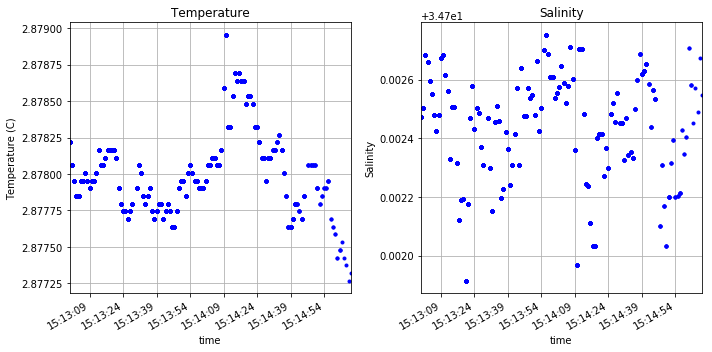

In [7]:
# set up your variable lists to extract from the json response
time_stamp = []
pressure = []
temperature = []
salinity = []
oxygen = []
conductivity = []

# establish a session
session = requests.session()

# enter request and plotting loop (100 * 10 sec)
# while True: # use for endless loop
for i in range(100):
    
    # send request for data
    response = session.get(data_request_url, params=params, auth=(username, token))
    data = response.json()
    
    # check for failed data request (200 means OK)
    if response.status_code != 200:
        print('Data request failed')
        print(data['message']['status'])
        break
    
    # get last time stamp in response
    last_time = nc.num2date(data[-1]['time'],'seconds since 1900-01-01').strftime("%Y-%m-%dT%H:%M:%S.000Z")
    
    # check if new data has been received
    if params['beginDT'] == last_time:
        continue
        
    # if new data is received, extract and append values to list, then plot
    else:
        # extract variables
        for i in range(len(data)):
            time_stamp.append(nc.num2date(data[i]['time'],'seconds since 1900-01-01').replace(microsecond=0))
            pressure.append(data[i]['seawater_pressure'])
            temperature.append(data[i]['seawater_temperature'])
            oxygen.append(data[i]['ctd_tc_oxygen'])
            salinity.append(data[i]['practical_salinity'])
            conductivity.append(data[i]['seawater_conductivity'])

        # remove colorbars for continuous replotting (there might be a better way to do this)
#        try:
#             cb1.remove()
#             cb2.remove()
#             cb3.remove()
#             cb4.remove()
#         except:
#             pass

        # set x axis limit to extent of data
        ax1.set_xlim(time_stamp[0],time_stamp[-1])
        ax2.set_xlim(time_stamp[0],time_stamp[-1])
#        ax3.set_xlim(time_stamp[0],time_stamp[-1])
#        ax4.set_xlim(time_stamp[0],time_stamp[-1])
#        ax1.set_ylim(min(temperature),max(temperature))
        fig.autofmt_xdate()

        # choose the colormaps. more colormaps at https://matplotlib.org/examples/color/colormaps_reference.html
#         cmap1 = plt.get_cmap("Reds")
#         cmap2 = plt.get_cmap("winter_r")
#         # cmap3 = plt.get_cmap("copper")
#         cmap4 = plt.get_cmap("copper")

        # plot the data
        ax1.plot(time_stamp, temperature, 'b.')
        ax2.plot(time_stamp, salinity, 'b.')
#        ax3.plot(time_stamp, oxygen, 'b.')
#        ax4.plot(time_stamp, conductivity, 'b.')

        # assign a colorbar 
#         cb1 = plt.colorbar(t,ax=ax1)
#         cb2 = plt.colorbar(o,ax=ax2)
#         cb3 = plt.colorbar(s,ax=ax3)
#         cb4 = plt.colorbar(c,ax=ax4)

        # label colorbars
#         cb1.set_label('$^\circ$C')
#         cb2.set_label('umol/Kg')
#         cb3.set_label('1')
#         cb4.set_label('S/m')

        # label subplots
        ax1.set_title("Temperature")
        ax2.set_title("Salinity")
#        ax3.set_title("Oxygen")
#        ax4.set_title("Conductivity")

        ax1.set_ylabel('Temperature (C)')
        ax2.set_ylabel('Salinity')
#        ax3.set_ylabel('Oxygen')
#        ax4.set_ylabel('Conductivity')

        ax1.set_xlabel('time')
        ax2.set_xlabel('time')

        # tighten layout and display plot
        spec.tight_layout(fig)

        display.clear_output(wait=True)
        display.display(plt.gcf())
    
    
    # reset beginDT for next request    
    params['beginDT'] = last_time
    
plt.close()

The above loop is set to continuously run until the limit is reached.  You can set the limit to a higher number to run this script as long as desired.

## Loading xarray
Before we get started, we first need to install and load the xarray library into Google Colab.

In [ ]:
import xarray as xr
import requests
import os
import re
import pandas as pd

## Creating and downloading a CSV file
Above we converted our xarray Dataset into a pandas Dataframe.  Xarray is great for loading and exporting netcdf data, while Pandas is great for doing the same with CSV.

Now that we have our data in a pandas Dataframe, we can easily use the `.to_csv()` method to create a CSV file.  It shows up in menu at left.

In [ ]:
df.to_csv('Chadwick_test1_output.csv') # Create the CSV file